### Feature Selection Methods (all with SVM)
1. [Baseline scores](#baseline)
2. [Univariate: f_regression](#fregression)
    - predictions made with f-regression on dataframe xb


3. [Cosine similarity between bioreps](#cosreps)
4. [Spearman similarity between bioreps](#spearreps)
5. [Pearson similarity between bioreps](#pearreps)


6. [Cosine similarity between treatments](#costreat)


7. [Spearman correlation with target](#speartar)
8. [Pearson correlation with target](#peartar)
9. [Cosine similarity with target](#costar)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [2]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")
test_data = pd.read_csv("SubCh1_TestData.csv")

train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

print(train_data.shape)
train_data.head()

(272, 5546)


,Sample_Name,Isolate,Timepoint,Treatment,BioRep,MAL1.465720.465873.bc..rv..,MAL1.48287.48430....kr...can,MAL1.562126.562246.bc..r...,MAL1.59416.59687....kr...can,MAL1.616633.616682.......y.,...,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,DHA_IC50
0,isolate_01.24HR.DHA.BRep1,isolate_01,1,1,1,0.008286,-0.959492,0.206468,-0.443936,0.453030,...,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528,2.177
1,isolate_01.24HR.DHA.BRep2,isolate_01,1,1,2,-0.872028,-1.968558,-2.308563,-1.186611,0.508575,...,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568,2.177
2,isolate_01.24HR.UT.BRep1,isolate_01,1,0,1,0.039480,-1.291371,-0.946661,-0.538092,-1.778501,...,1.411557,-5.500522,-1.764229,-1.947208,-5.331037,-0.814417,-2.141285,-3.922684,-2.495169,2.177
3,isolate_01.24HR.UT.BRep2,isolate_01,1,0,2,0.125177,-1.462758,-1.888105,-0.828352,-1.410803,...,-0.659519,-5.011207,-0.559471,-2.266763,-5.289318,-2.949869,-2.206432,-4.324299,-1.735312,2.177
4,isolate_01.6HR.DHA.BRep1,isolate_01,0,1,1,1.354956,-2.139128,-0.541696,-1.481881,-0.735798,...,-1.687048,-4.773306,-0.048847,-2.023727,-4.398358,-3.080500,-0.566545,-4.798190,-0.821690,2.177


In [5]:
X_A = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_B = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_C = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_D = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

# rename columns:
X_A.columns = ['A' + str(i) for i in range(1,5541)]
X_B.columns = ['B' + str(i) for i in range(1,5541)]
X_C.columns = ['C' + str(i) for i in range(1,5541)]
X_D.columns = ['D' + str(i) for i in range(1,5541)]

X_A = X_A.reset_index().drop(['index'],axis=1)
X_B = X_B.reset_index().drop(['index'],axis=1)
X_C = X_C.reset_index().drop(['index'],axis=1)
X_D = X_D.reset_index().drop(['index'],axis=1)

# combine data frames:
X = pd.concat([X_A,X_B,X_C,X_D], axis=1)
print("X shape = ", X.shape)

# create target column
y = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)][['DHA_IC50']]
y.reset_index(inplace = True, drop = True)
print("y shape = ", y.shape)

X.head()

X shape =  (68, 22160)
y shape =  (68, 1)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D5531,D5532,D5533,D5534,D5535,D5536,D5537,D5538,D5539,D5540
0,1.311350,-1.613464,-1.298663,-1.441343,-1.735923,0.173112,2.466366,1.383979,-0.115130,0.287468,...,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528
1,0.997722,-1.553994,-1.960600,-1.424590,0.023609,0.420973,1.128427,0.722659,1.878123,-0.065159,...,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568
2,0.389508,-2.139782,-0.584985,-1.085373,0.803247,0.766617,1.701689,0.926101,1.600687,0.435633,...,-0.070151,0.024133,-2.215227,-1.957654,-2.188635,-4.424748,-2.986927,-1.722201,-3.995680,-0.902979
3,0.348560,-1.562540,-0.586732,-0.834661,1.096979,0.121817,1.623373,-0.654405,0.221121,0.998601,...,-1.288305,0.806314,-3.733712,-1.990368,-1.633418,-5.533077,-3.283316,-2.104227,-5.767710,-2.177930
4,0.138276,-1.612280,-1.362990,-1.360318,0.488124,0.365410,0.739845,-0.654702,2.170263,0.630418,...,0.279816,0.115002,-1.305902,-0.679212,-2.099512,-5.955507,-0.920594,-1.626372,-4.422711,-1.408485


In [41]:
a_name = ['A' + str(i) for i in range(1,5541)]
b_name = ['B' + str(i) for i in range(1,5541)]
c_name = ['C' + str(i) for i in range(1,5541)]
d_name = ['D' + str(i) for i in range(1,5541)]

xa = X.loc[:,a_name]
xb = X.loc[:,b_name]
xc = X.loc[:,c_name]
xd = X.loc[:,d_name]

# df_list = [X, xa, xb, xc, xd]

X_frames = ['X', 'xa', 'xb', 'xc', 'xd']
y_frames = ['y', 'y', 'y', 'y', 'y']

In [ ]:
def spear_r(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

import warnings
warnings.filterwarnings("ignore", message="invalid value encountered")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

## 1.Baseline Score

In [19]:
dataframe = []    #for best gridsearch results
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    X_train, X_test, y_train, y_test = train_test_split(x_frame, y_frame.values.ravel(), 
                                                        test_size = 0.33, random_state = 33)
#gridsearch results
    svc = svm.SVR()
    params = {        
                 'kernel': ['rbf', 'poly', 'sigmoid'],
                      'C': [0.01, 0.1, 1, 5],
                'epsilon': [0.01,  0.1, 0.2],
                  'gamma': [0.001, 0.01, 'auto'], 
                 'degree': [2, 4, 6]                  }

    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
    gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                      return_train_score=True, scoring = scoring, refit = 'spear_r')
    gs.fit(X_train, y_train) 
    gs_results = pd.DataFrame(gs.cv_results_)
    best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results (cv=3)   
    dataframe.append(x[0])
    best_params.append(best_scores_df.loc[0, 'params'])
    gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
    gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
    gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
    gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
    gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
    gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
# final score using the best gridsearch params
    svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                 epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)
    train_pred = model.predict(X_train)
#for final score df        
    test_spear.append(round(spearmanr(y_test, pred)[0], 3))
    test_r2.append(round(r2_score(y_test, pred), 3))
    test_mse.append(round(mean_squared_error(y_test, pred), 3))
    test_pval.append(round(spearmanr(y_test, pred)[1], 3))
    train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
    train_r2.append(round(r2_score(y_train, train_pred), 3))
    train_mse.append(round(mean_squared_error(y_train, train_pred), 3))


all_results = pd.DataFrame(list(zip(dataframe, best_params, gs_test_spear, gs_train_spear, gs_test_r2, gs_train_r2, 
                    gs_test_mse, gs_train_mse, test_spear, train_spear, test_r2, train_r2, 
                    test_mse, train_mse, test_pval)),
            columns=['x_frame', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 'gs_train_r2',
                     'gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [20]:
baseline_results = all_results.loc[:]
baseline_results['best_params'].values

array([{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 6, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 1, 'degree': 6, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}],
      dtype=object)

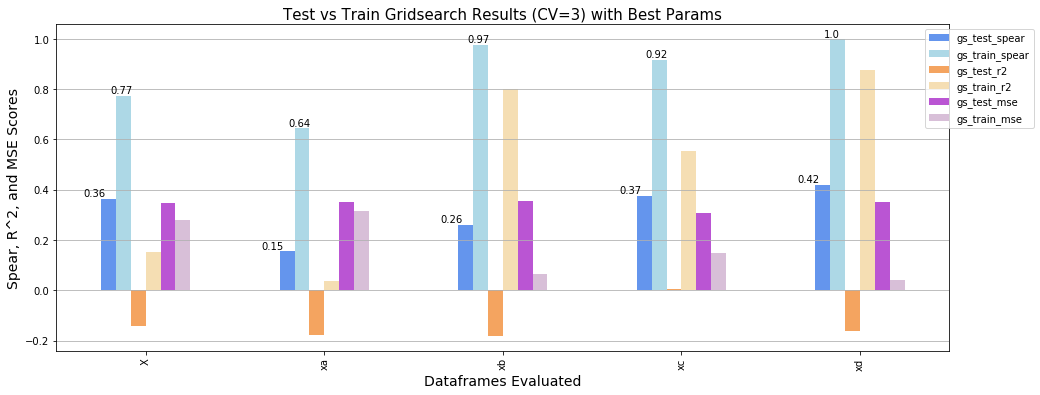

In [21]:
baseline_gs = baseline_results.loc[:, ['x_frame', 'gs_test_spear','gs_train_spear','gs_test_r2', 'gs_train_r2',
                     'gs_test_mse', 'gs_train_mse']].set_index('x_frame')

color_list = ['cornflowerblue','lightblue','sandybrown','wheat','mediumorchid','thistle']

f = plt.figure(figsize = (16, 6))
ax = baseline_gs.plot(kind = 'bar', color = color_list, ax=f.gca())

ax.set_title("Test vs Train Gridsearch Results (CV=3) with Best Params", fontsize = 15)
ax.set_xlabel("Dataframes Evaluated", fontsize = 14)
ax.set_ylabel("Spear, R^2, and MSE Scores", fontsize = 14)
plt.legend(loc = 'upper right', bbox_to_anchor=(1.1 ,1))
ax.yaxis.grid()
for index, value in enumerate(baseline_gs['gs_test_spear']):
    plt.annotate(round(value, 2), xy=(index-0.35, value+0.01))
for index, value in enumerate(baseline_gs['gs_train_spear']):
    plt.annotate(round(value, 2), xy=(index - 0.2, value+0.01))

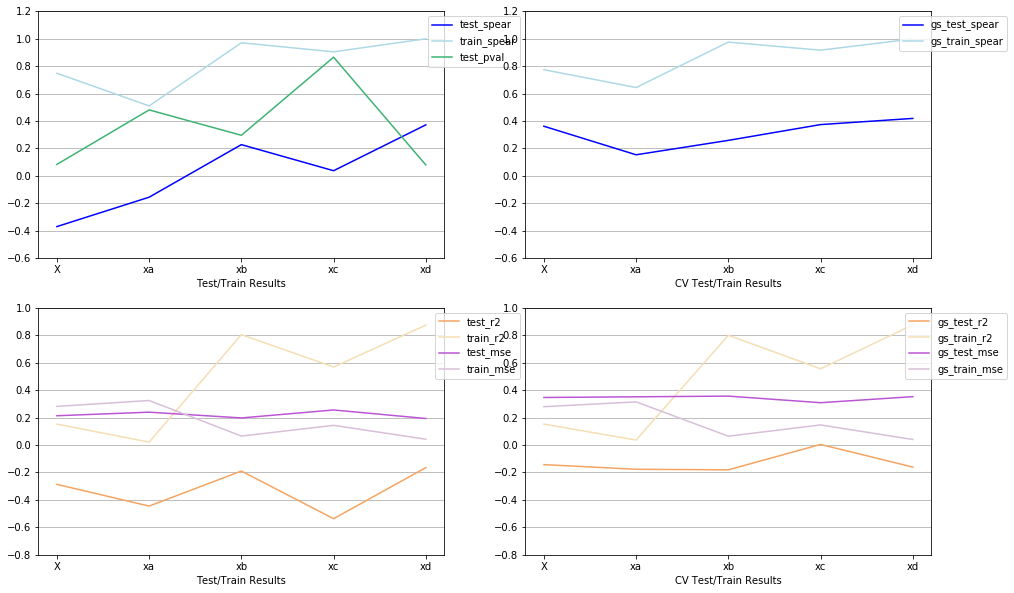

In [22]:
base_1 = baseline_results.loc[:, ['x_frame', 'test_spear', 'train_spear', 'test_pval']].set_index('x_frame')
base_2 = baseline_results.loc[:, ['x_frame', 'test_r2', 'train_r2', 'test_mse', 'train_mse']].set_index('x_frame')
gs_1 = baseline_results.loc[:, ['gs_test_spear', 'gs_train_spear']]
gs_2 = baseline_results.loc[:, ['gs_test_r2', 'gs_train_r2', 'gs_test_mse', 'gs_train_mse']]


plt.figure(figsize = (16, 10))
ax1 = plt.subplot(221)
base_1.plot(kind = 'line', ax = ax1, color = ['blue','lightblue', 'mediumseagreen' ])
plt.xlabel("Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax1.get_yticks())
ax1.yaxis.grid()
ax1.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))

ax2 = plt.subplot(222)
gs_1.plot(kind = 'line', ax = ax2, color = ['blue','lightblue'])
plt.xlabel("CV Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax1.get_yticks())
ax2.yaxis.grid()
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))

ax3 = plt.subplot(223)
base_2.plot(kind = 'line', ax = ax3, color = ['sandybrown','wheat','mediumorchid','thistle'])
plt.xlabel("Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax3.get_yticks())
ax3.yaxis.grid()
ax3.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))

ax4 = plt.subplot(224)
gs_2.plot(kind = 'line', ax = ax4, color = ['sandybrown','wheat','mediumorchid','thistle'])
plt.xlabel("CV Test/Train Results")
plt.xticks(np.arange(0, len(X_frames), 1), X_frames)
plt.yticks(ax3.get_yticks())
ax4.yaxis.grid()
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
plt.show()

# Feature Selection Methods

<a id='fregression'><a/>
## 2. Univariate f-regression

In [23]:
dataframe = []    #for gridsearch results
k_features = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []


for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]

    for j in np.arange(10, 260, 40):
        X_new = SelectKBest(f_regression, k=j).fit_transform(x_frame , y_frame.values.ravel()) 
        X_new = pd.DataFrame(data = X_new)

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
    #gridsearch results
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#         print(best_scores_df['params'].values)
#         print("----------------------------------------------------------")
    #gridsearch results df    
        dataframe.append(x[0])
        k_features.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
    # final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
    #for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, k_features, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'k=features', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])


In [24]:
f_results = all_results.loc[:]
f_bestparams = f_results['best_params'].values
for i, row in enumerate(f_bestparams):
    print(i, row)

0 {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
1 {'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
2 {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'sigmoid'}
3 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'}
4 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'sigmoid'}
5 {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'sigmoid'}
6 {'C': 5, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
7 {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
8 {'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
9 {'C': 5, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
10 {'C': 1, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
11 {'C': 1, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'poly'}
12 {'C': 0.01, 'degree': 6, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'poly'}
13 {'C': 0.

In [25]:
f_results.drop('best_params', axis = 1)

,x_frame,k=features,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,10,0.574,0.713,0.367,0.505,0.209,0.167,0.309,0.717,0.120,0.496,0.146,0.167,0.151
1,X,50,0.596,0.932,0.279,0.855,0.217,0.047,0.254,0.917,-0.145,0.826,0.190,0.058,0.243
2,X,90,0.662,0.812,0.315,0.489,0.217,0.166,0.281,0.790,0.109,0.494,0.148,0.167,0.193
3,X,130,0.636,0.915,0.365,0.914,0.193,0.027,0.359,0.933,0.038,0.916,0.159,0.028,0.093
4,X,170,0.648,0.844,0.307,0.552,0.219,0.145,0.341,0.840,0.088,0.591,0.151,0.135,0.111
5,X,210,0.639,0.854,0.316,0.587,0.216,0.134,0.345,0.866,0.185,0.604,0.135,0.131,0.107
6,X,250,0.692,0.909,0.393,0.682,0.191,0.103,0.335,0.918,0.108,0.701,0.148,0.099,0.118
7,xa,10,0.434,0.164,0.010,-0.018,0.314,0.329,-0.038,0.248,-0.596,0.061,0.265,0.311,0.865
8,xa,50,0.426,0.480,-0.044,0.057,0.321,0.309,0.222,0.460,-0.122,0.077,0.186,0.306,0.308
9,xa,90,0.405,0.819,-0.072,0.385,0.327,0.194,-0.088,0.803,-0.057,0.397,0.175,0.200,0.689


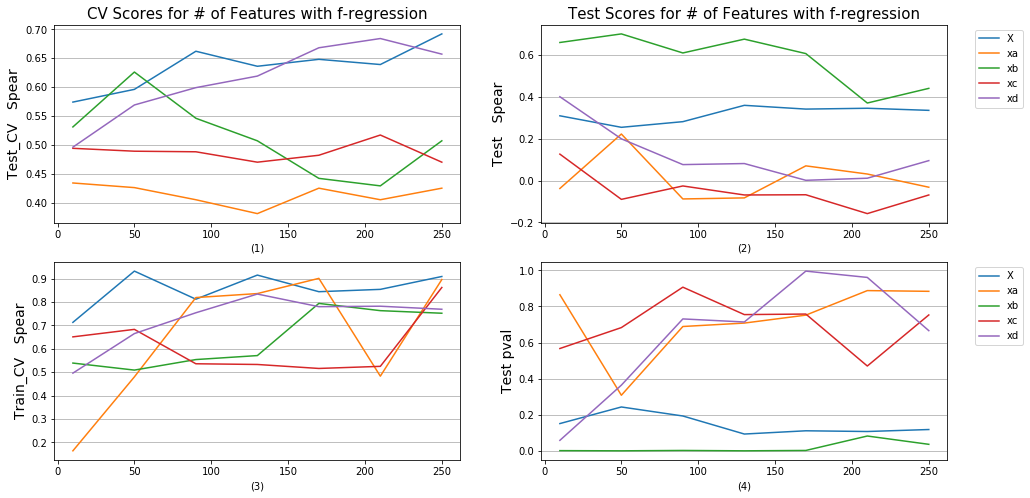

--------------------------------------------------------------------------


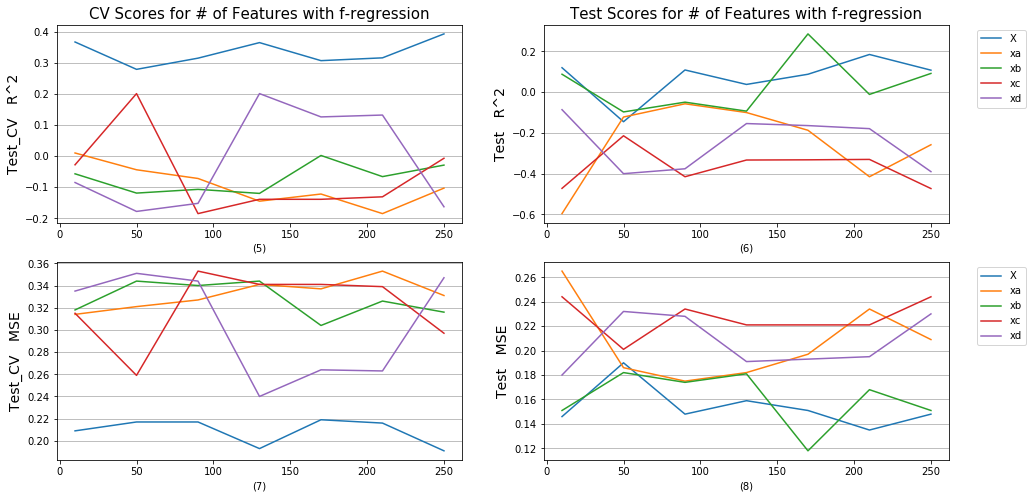

In [26]:
plt.figure(figsize = (16, 8))
ax1 = plt.subplot(221)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_spear'], label = j)
ax1.yaxis.grid()
plt.xlabel("(1)")
ax1.set_title("CV Scores for # of Features with f-regression", fontsize = 15)
ax1.set_ylabel("Test_CV   Spear", fontsize = 14)


ax2 = plt.subplot(222)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_spear'], label = j)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax2.yaxis.grid()
plt.xlabel("(2)")
ax2.set_title("Test Scores for # of Features with f-regression", fontsize = 15)
ax2.set_ylabel("Test   Spear", fontsize = 14)

ax3 = plt.subplot(223)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_train_spear'], label = j)
ax3.yaxis.grid()
plt.xlabel("(3)")
ax3.set_ylabel("Train_CV   Spear", fontsize = 14)


ax4 = plt.subplot(224)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_pval'], label = j)
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax4.yaxis.grid()
plt.xlabel("(4)")
ax4.set_ylabel("Test pval", fontsize = 14)
plt.show()
print("--------------------------------------------------------------------------")
plt.figure(figsize = (16, 8))
ax1 = plt.subplot(221)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_r2'], label = j)
ax1.yaxis.grid()
plt.xlabel("(5)")
ax1.set_title("CV Scores for # of Features with f-regression", fontsize = 15)
ax1.set_ylabel("Test_CV   R^2", fontsize = 14)

ax2 = plt.subplot(222)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_r2'], label = j)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax2.yaxis.grid()
plt.xlabel("(6)")
ax2.set_title("Test Scores for # of Features with f-regression", fontsize = 15)
ax2.set_ylabel("Test   R^2", fontsize = 14)

ax3 = plt.subplot(223)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_mse'], label = j)
ax3.yaxis.grid()
plt.xlabel("(7)")
ax3.set_ylabel("Test_CV   MSE", fontsize = 14)

ax4 = plt.subplot(224)
for j in X_frames:
    condition = f_results[f_results['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_mse'], label = j)
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax4.yaxis.grid()
plt.xlabel("(8)")
ax4.set_ylabel("Test   MSE", fontsize = 14)

plt.show()

**Results of f-regression feature selection:**
- `xb` performs better than `X` with lower # of features



# Looking closer at just two dataframes: X and xb
- extend the C param and the threshold

In [100]:
np.arange(20, 190, 10)

array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180])

In [113]:
X_frames = ['X', 'xb']
y_frames = ['y', 'y']

dataframe = []    #for gridsearch results
k_features = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []


for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]

    for j in np.arange(20, 190, 10):
        X_new = SelectKBest(f_regression, k=j).fit_transform(x_frame , y_frame.values.ravel()) 
        X_new = pd.DataFrame(data = X_new)

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.25, random_state = 33)
    #gridsearch results
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#         print(best_scores_df['params'].values)
#         print("----------------------------------------------------------")
    #gridsearch results df    
        dataframe.append(x[0])
        k_features.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
    # final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
    #for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, k_features, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'k=features', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [114]:
f_results_2 = all_results.loc[:]
f_bestparams_2 = f_results_2['best_params'].values
for i, row in enumerate(f_bestparams_2):
    print(i, row)

0 {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'}
1 {'C': 2, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
2 {'C': 1.5, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}
3 {'C': 1.5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
4 {'C': 2, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
5 {'C': 1.5, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
6 {'C': 2, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
7 {'C': 1.5, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
8 {'C': 2, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
9 {'C': 2, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
10 {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
11 {'C': 0.5, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
12 {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
13 {'C':

In [115]:
f_results_2.drop('best_params', axis = 1)

,x_frame,k=features,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,20,0.657,0.755,0.280,0.528,0.220,0.152,0.236,0.755,0.117,0.567,0.134,0.141,0.361
1,X,30,0.680,0.719,0.391,0.504,0.198,0.163,0.145,0.692,-0.244,0.463,0.189,0.175,0.578
2,X,40,0.648,0.730,0.328,0.504,0.216,0.161,0.122,0.729,-0.046,0.540,0.159,0.150,0.641
3,X,50,0.627,0.730,0.250,0.452,0.239,0.177,0.100,0.725,0.021,0.478,0.148,0.170,0.703
4,X,60,0.698,0.813,0.385,0.616,0.200,0.125,0.262,0.766,0.107,0.574,0.135,0.139,0.309
5,X,70,0.732,0.920,0.448,0.811,0.172,0.062,0.208,0.927,-0.082,0.815,0.164,0.060,0.423
6,X,80,0.733,0.960,0.455,0.845,0.173,0.051,0.183,0.961,-0.121,0.833,0.170,0.054,0.481
7,X,90,0.740,0.947,0.444,0.815,0.178,0.059,0.299,0.945,0.075,0.834,0.140,0.054,0.244
8,X,100,0.709,0.950,0.416,0.847,0.182,0.049,0.284,0.956,0.072,0.862,0.141,0.045,0.269
9,X,110,0.716,0.989,0.437,0.894,0.175,0.034,0.313,0.989,0.035,0.898,0.146,0.033,0.222


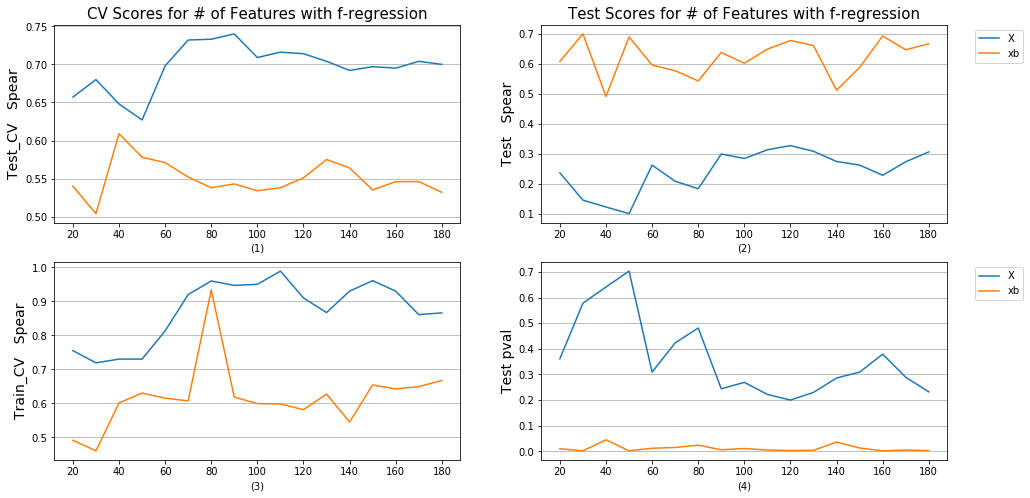

--------------------------------------------------------------------------


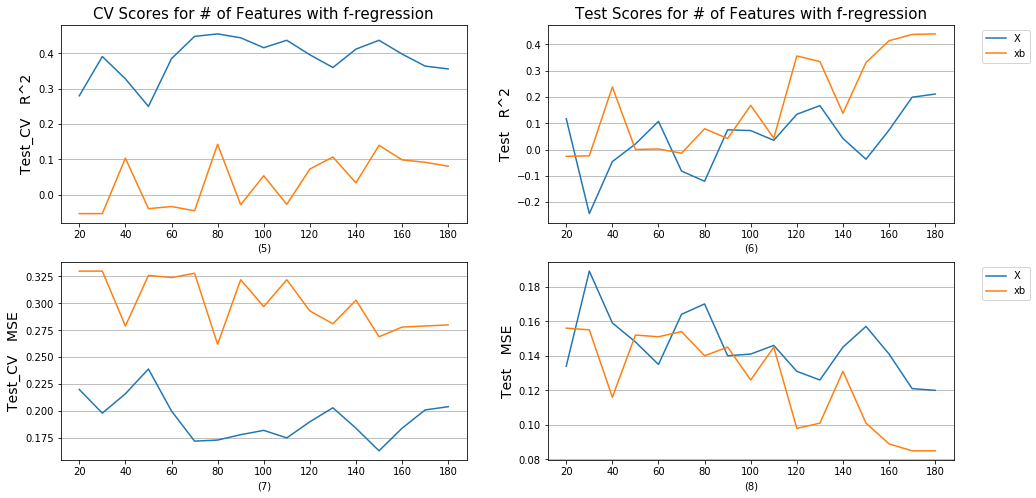

In [116]:
plt.figure(figsize = (16, 8))
ax1 = plt.subplot(221)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_spear'], label = j)
ax1.yaxis.grid()
plt.xlabel("(1)")
ax1.set_title("CV Scores for # of Features with f-regression", fontsize = 15)
ax1.set_ylabel("Test_CV   Spear", fontsize = 14)


ax2 = plt.subplot(222)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_spear'], label = j)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax2.yaxis.grid()
plt.xlabel("(2)")
ax2.set_title("Test Scores for # of Features with f-regression", fontsize = 15)
ax2.set_ylabel("Test   Spear", fontsize = 14)

ax3 = plt.subplot(223)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_train_spear'], label = j)
ax3.yaxis.grid()
plt.xlabel("(3)")
ax3.set_ylabel("Train_CV   Spear", fontsize = 14)


ax4 = plt.subplot(224)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_pval'], label = j)
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax4.yaxis.grid()
plt.xlabel("(4)")
ax4.set_ylabel("Test pval", fontsize = 14)
plt.show()
print("--------------------------------------------------------------------------")
plt.figure(figsize = (16, 8))
ax1 = plt.subplot(221)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_r2'], label = j)
ax1.yaxis.grid()
plt.xlabel("(5)")
ax1.set_title("CV Scores for # of Features with f-regression", fontsize = 15)
ax1.set_ylabel("Test_CV   R^2", fontsize = 14)

ax2 = plt.subplot(222)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_r2'], label = j)
ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax2.yaxis.grid()
plt.xlabel("(6)")
ax2.set_title("Test Scores for # of Features with f-regression", fontsize = 15)
ax2.set_ylabel("Test   R^2", fontsize = 14)

ax3 = plt.subplot(223)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['gs_test_mse'], label = j)
ax3.yaxis.grid()
plt.xlabel("(7)")
ax3.set_ylabel("Test_CV   MSE", fontsize = 14)

ax4 = plt.subplot(224)
for j in X_frames:
    condition = f_results_2[f_results_2['x_frame'] == j]
    plt.plot(condition['k=features'], condition['test_mse'], label = j)
ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
ax4.yaxis.grid()
plt.xlabel("(8)")
ax4.set_ylabel("Test   MSE", fontsize = 14)

plt.show()

In [138]:
results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'X', 'xb'])
# results_df['Actual'] = y['DHA_IC50']
# # results_df
# for j in enumerate(X_test.index):
#     print(j)
    
# results_df.columns
# pred[1]

## Get the predictions from the best params found with 70 features for the 2 best dataframes

In [164]:
X_frames = ['X', 'xb']
y_frames = ['y', 'y']

results_df = pd.DataFrame(index = X.index, columns = ['Actual', 'X', 'xb'])
results_df['Actual'] = y['DHA_IC50']

dataframe = []    #for gridsearch results
k_features = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []


for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]

   
    j = 70 #only use 70 features

    k_best_selector = SelectKBest(f_regression, k=j).fit(x_frame , y_frame.values.ravel())
    X_new = k_best_selector.fit_transform(x_frame, y_frame.values.ravel())
    
#     X_new = SelectKBest(f_regression, k=j).fit_transform(x_frame , y_frame.values.ravel()) 
    X_new = pd.DataFrame(data = X_new)

    X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                        test_size = 0.33, random_state = 33)
#gridsearch results
    svc = svm.SVR()
    params = {        
                 'kernel': ['rbf', 'poly', 'sigmoid'],
                      'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 5],
                'epsilon': [0.01,  0.1, 0.2],
                  'gamma': [0.001, 0.01, 'auto'], 
                 'degree': [2, 4, 6]                  }

    scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
    gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                      return_train_score=True, scoring = scoring, refit = 'spear_r')
    gs.fit(X_train, y_train) 
    gs_results = pd.DataFrame(gs.cv_results_)
    best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#         print(best_scores_df['params'].values)
#         print("----------------------------------------------------------")
#gridsearch results df    
    dataframe.append(x[0])
    k_features.append(j)
    best_params.append(best_scores_df.loc[0, 'params'])
    gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
    gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
    gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
    gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
    gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
    gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
# final score using the best gridsearch params
    svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                 epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
    model = svc.fit(X_train, y_train)
    pred = model.predict(X_test)
    train_pred = model.predict(X_train)
#for final score df             
    test_spear.append(round(spearmanr(y_test, pred)[0], 3))
    test_r2.append(round(r2_score(y_test, pred), 3))
    test_mse.append(round(mean_squared_error(y_test, pred), 3))
    test_pval.append(round(spearmanr(y_test, pred)[1], 3))
    train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
    train_r2.append(round(r2_score(y_train, train_pred), 3))
    train_mse.append(round(mean_squared_error(y_train, train_pred), 3))

##for predictions
    for p in enumerate(X_test.index):
        results_df.loc[p[1], x[0]] = round(float(pred[p[0]]), 3)
    
    

all_results = pd.DataFrame(list(zip(dataframe, k_features, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'k=features', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])


    
results_df = results_df.dropna(subset = ['xb'])
results_df = results_df.astype(float)
results_df['avg'] = (results_df['X'] + results_df['xb']) / 2
results_df

,Actual,X,xb,avg
1,2.1770,2.092,1.557,1.8245
2,1.6970,2.207,1.616,1.9115
4,1.6970,1.642,1.578,1.6100
5,1.6970,0.959,1.538,1.2485
6,1.7990,1.671,1.636,1.6535
8,0.7100,1.401,1.462,1.4315
15,0.8567,0.698,1.511,1.1045
21,1.7540,1.626,1.604,1.6150
25,1.5170,1.761,1.558,1.6595
27,1.7230,1.314,1.690,1.5020


In [ ]:
k_best_selector

In [165]:
print(spearmanr(results_df['X'], results_df['Actual']))
print(spearmanr(results_df['xb'], results_df['Actual']))
print(spearmanr(results_df['avg'], results_df['Actual']))

SpearmanrResult(correlation=0.49529621915532795, pvalue=0.01625644613055974)
SpearmanrResult(correlation=0.6883066048915184, pvalue=0.0002826258288826457)
SpearmanrResult(correlation=0.5473023221666374, pvalue=0.006873249373135931)


In [167]:
f_names = xb.columns.values[k_best_selector.get_support()]  
f_names


array(['B13', 'B60', 'B132', 'B176', 'B178', 'B197', 'B271', 'B389',
       'B490', 'B506', 'B578', 'B672', 'B825', 'B887', 'B945', 'B957',
       'B1092', 'B1184', 'B1186', 'B1370', 'B1708', 'B1713', 'B1736',
       'B1827', 'B1895', 'B1929', 'B2136', 'B2219', 'B2431', 'B2476',
       'B2484', 'B2602', 'B2639', 'B2713', 'B2721', 'B2870', 'B2945',
       'B3000', 'B3018', 'B3142', 'B3398', 'B3402', 'B3449', 'B3462',
       'B3490', 'B3491', 'B3492', 'B3595', 'B3638', 'B3689', 'B3694',
       'B3728', 'B3777', 'B3834', 'B3854', 'B3968', 'B3987', 'B4030',
       'B4037', 'B4090', 'B4328', 'B4469', 'B4565', 'B4644', 'B4848',
       'B5119', 'B5243', 'B5244', 'B5317', 'B5482'], dtype=object)

## submission with just using xb

In [159]:
#test data:
test_data['Timepoint'] = [1 if i == '24HR' else 0 for i in test_data['Timepoint']]
test_data['Treatment'] = [1 if i == 'DHA' else 0 for i in test_data['Treatment']]
test_data['BioRep'] = [int(i[-1]) for i in test_data['BioRep']]


# split test data:
Xt_A = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_B = test_data[(test_data['Timepoint'] == 1)&(test_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_C = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_D = test_data[(test_data['Timepoint'] == 1)&(test_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)


# rename test data columns
Xt_A.columns = ['A' + str(i) for i in range(1,5541)]
Xt_B.columns = ['B' + str(i) for i in range(1,5541)]
Xt_C.columns = ['C' + str(i) for i in range(1,5541)]
Xt_D.columns = ['D' + str(i) for i in range(1,5541)]


Xt_A = Xt_A.reset_index().drop(['index'],axis=1)
Xt_B = Xt_B.reset_index().drop(['index'],axis=1)
Xt_C = Xt_C.reset_index().drop(['index'],axis=1)
Xt_D = Xt_D.reset_index().drop(['index'],axis=1)
# reset indices

# combine data frames:
Xt = pd.concat([Xt_A,Xt_B,Xt_C,Xt_D], axis=1)

In [172]:
Xt_B_new = Xt_B[f_names]
Xt_B_new.head()

,B13,B60,B132,B176,B178,B197,B271,B389,B490,B506,...,B4328,B4469,B4565,B4644,B4848,B5119,B5243,B5244,B5317,B5482
0,-0.736499,1.261167,0.035100,0.555372,0.373014,-0.455280,-0.055995,0.621649,-0.061037,-0.198267,...,0.151846,0.981828,0.512968,-0.067048,0.276461,-0.794764,0.141353,0.060072,0.393365,0.494047
1,-0.318073,1.379240,-0.165186,0.761351,1.028813,-0.785378,-0.025450,0.636687,-0.425688,-0.656275,...,-0.192932,0.591944,0.958390,-0.418922,0.058202,0.152144,0.330116,0.684250,0.502950,0.945774
2,-1.026102,1.046637,-0.374188,1.111462,0.936767,0.393530,-0.530954,1.122006,-2.290466,-1.409880,...,-0.612838,0.581801,-0.260253,-0.443298,0.152261,-0.622463,-0.122344,0.771900,0.697235,0.355866
3,0.156029,2.161398,0.083441,1.112456,1.154276,-0.326906,-0.333643,1.640831,-1.639945,-0.513396,...,-0.763042,1.242902,0.267092,0.020720,0.009924,0.546034,-0.004378,0.565541,0.180082,0.382947
4,-0.221152,0.799381,0.133368,0.381336,-0.271586,-1.460172,0.292205,0.231387,0.328224,0.273440,...,0.360189,0.705811,1.690297,0.577850,0.847449,0.131866,-0.979990,-0.321974,0.542096,1.251744


In [173]:
test_pred = model.predict(Xt_B_new)
test_pred

array([1.34691013, 1.63118471, 1.55179889, 1.62082776, 1.64029527,
       1.51248597, 1.59813903, 1.65408901, 1.53797972, 1.52971896,
       1.54768527, 1.53185218, 1.52718365, 1.50051306, 1.54176727,
       1.61081993, 1.54330121, 1.77297706, 1.65253679, 1.64918155,
       1.58763339, 1.4683643 , 1.59617019, 1.53899911, 1.57846369,
       1.56090446, 1.57375497, 1.60996231, 1.77387258, 1.68165076,
       1.45573749, 1.5996851 , 1.53960155, 1.52774624, 1.56577873,
       1.59949243, 1.58842559, 1.46943011, 1.51512801, 1.6290808 ,
       1.52330424, 1.5900269 , 1.54507186, 1.5389632 , 1.52772148,
       1.53870914, 1.53721229, 1.60943426, 1.76057787, 1.71339206])

In [174]:
# average predictions over isolates
predictions = []
isolates = []
differences = []
for i in range(int(len(test_pred)/2)):
    isolates.append('isolate_'+str(i+31))
    predictions.append((test_pred[2*i]+test_pred[2*i+1])/2.)
    differences.append(abs(test_pred[2*i]-test_pred[2*i+1]))

In [175]:
# export to tsv
predict = pd.DataFrame(list(zip(isolates,predictions)),columns=['Isolate','Predicted_IC50'])
# predict.to_csv('SubCh1_Submission3.txt', index=None, header=True,sep='\t')
predict

,Isolate,Predicted_IC50
0,isolate_31,1.489047
1,isolate_32,1.586313
2,isolate_33,1.576391
3,isolate_34,1.626114
4,isolate_35,1.533849
5,isolate_36,1.539769
6,isolate_37,1.513848
7,isolate_38,1.576294
8,isolate_39,1.658139
9,isolate_40,1.650859


<a id='cosreps'><a/>
    
## 3. Cosine similarty between bioreps (drop features that are NOT similar between reps (below a certain cos sim threshold))
- Idea: Significant genes might not have wildly different measurements in rep 1 vs 2 ---> if a feature in biorep 1 and biorep 2 are NOT within a certain cosine similarity threshold, drop them

In [28]:
dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['BioRep'] = train_data['BioRep']       #add the biorep column to modified df
    reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

#iterate thru cosine sim threshold   
    for j in np.arange(0.4, 1.0, 0.08):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if cosine_similarity(reps2.values[:,i].reshape(1, -1),reps1.values[:,i].reshape(1, -1))[0][0] < drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names,axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])



In [29]:
cos_reps_results = all_results.loc[:]
cos_reps_bestparams = cos_reps_results['best_params'].values
cos_reps_bestparams

array([{'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'rbf'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'},
       {'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'},
       {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'},
 

In [30]:
cos_reps_results.drop('best_params', axis = 1).head()

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,0.40,9140,0.386,0.906,-0.084,0.105,0.334,0.293,-0.420,0.898,-0.207,0.113,0.200,0.294,0.046
1,X,0.48,7522,0.392,0.977,-0.058,0.650,0.327,0.116,-0.438,0.972,-0.593,0.626,0.264,0.124,0.037
2,X,0.56,5939,0.379,0.912,-0.088,0.112,0.335,0.291,-0.427,0.903,-0.206,0.118,0.200,0.292,0.042
3,X,0.64,4444,0.395,0.735,-0.116,-0.001,0.343,0.327,-0.384,0.711,-0.116,-0.003,0.185,0.332,0.071
4,X,0.72,3041,0.383,0.691,-0.115,-0.003,0.343,0.328,-0.296,0.664,-0.112,-0.005,0.184,0.333,0.171


In [31]:
def graph_threshold_scores(df, title, x_ax):   
    plt.figure(figsize = (16, 8))
    ax1 = plt.subplot(221)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_test_spear'], label = j)
    ax1.yaxis.grid()
    plt.xlabel("(1)")
    ax1.set_title("CV Scores for" + title, fontsize = 15)
    ax1.set_ylabel("Test_CV   Spear", fontsize = 14)

    ax2 = plt.subplot(222)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_spear'], label = j)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax2.yaxis.grid()
    plt.xlabel("(2)")
    ax2.set_title("Test Scores for" + title, fontsize = 15)
    ax2.set_ylabel("Test   Spear", fontsize = 14)

    ax3 = plt.subplot(223)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_train_spear'], label = j)
    ax3.yaxis.grid()
    plt.xlabel("(3)")
    ax3.set_ylabel("Train_CV   Spear", fontsize = 14)


    ax4 = plt.subplot(224)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_pval'], label = j)
    ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax4.yaxis.grid()
    plt.xlabel("(4)")
    ax4.set_ylabel("Test pval", fontsize = 14)
    plt.show()
    print("--------------------------------------------------------------------------")
    plt.figure(figsize = (16, 8))
    ax1 = plt.subplot(221)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_test_r2'], label = j)
    ax1.yaxis.grid()
    plt.xlabel("(5)")
    ax1.set_title("CV Scores for" + title, fontsize = 15)
    ax1.set_ylabel("Test_CV   R^2", fontsize = 14)

    ax2 = plt.subplot(222)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_r2'], label = j)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax2.yaxis.grid()
    plt.xlabel("(6)")
    ax2.set_title("Test Scores for" + title, fontsize = 15)
    ax2.set_ylabel("Test   R^2", fontsize = 14)

    ax3 = plt.subplot(223)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['gs_test_mse'], label = j)
    ax3.yaxis.grid()
    plt.xlabel("(7)")
    ax3.set_ylabel("Test_CV   MSE", fontsize = 14)

    ax4 = plt.subplot(224)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['test_mse'], label = j)
    ax4.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax4.yaxis.grid()
    plt.xlabel("(8)")
    ax4.set_ylabel("Test   MSE", fontsize = 14)
    plt.show()
    print("--------------------------------------------------------------------------")
    plt.figure(figsize = (16, 8))
    ax1 = plt.subplot(221)
    for j in X_frames:
        condition = df[df['x_frame'] == j]
        plt.plot(condition[x_ax], condition['num_columns'], label = j)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.2,1))
    ax1.yaxis.grid()
    plt.xlabel("(9)")
    ax1.set_title("Number of Features Selected", fontsize = 15)
    ax1.set_ylabel("num_columns", fontsize = 14)
    plt.show()  
    return

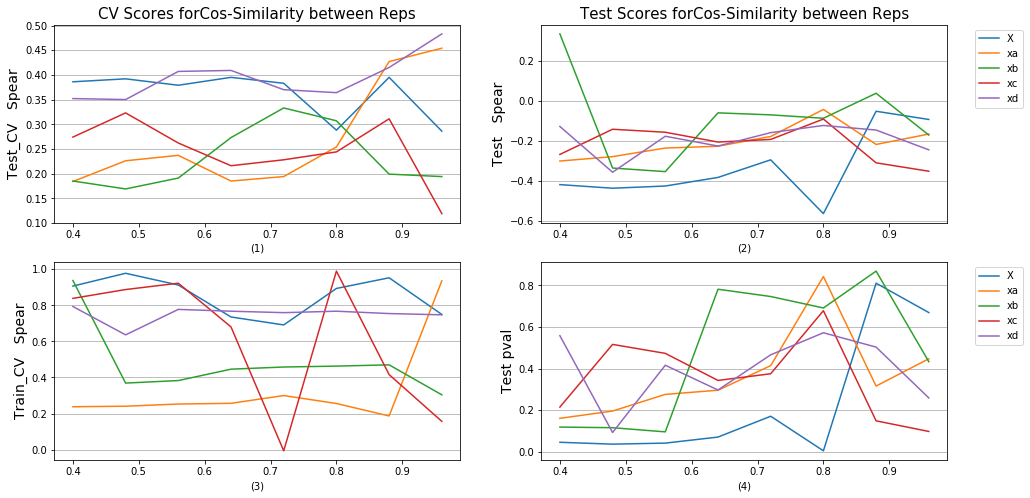

--------------------------------------------------------------------------


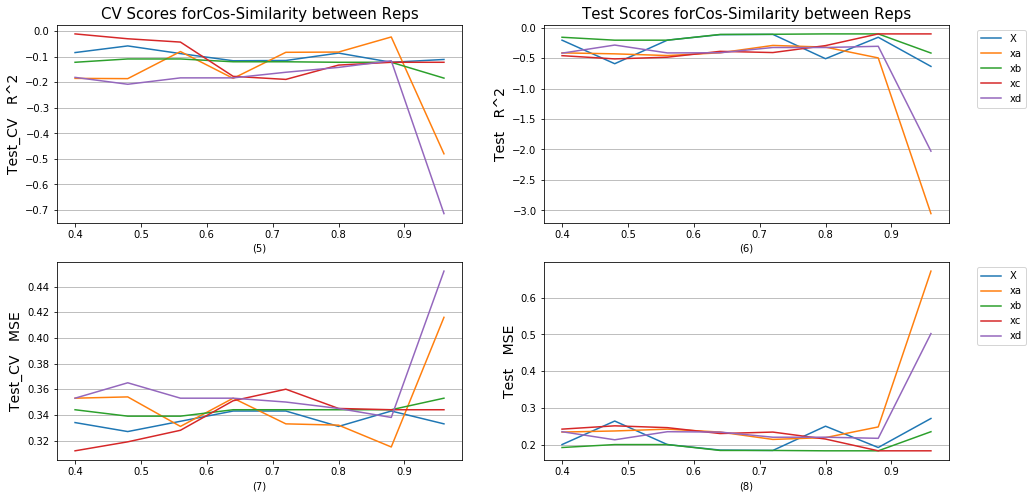

--------------------------------------------------------------------------


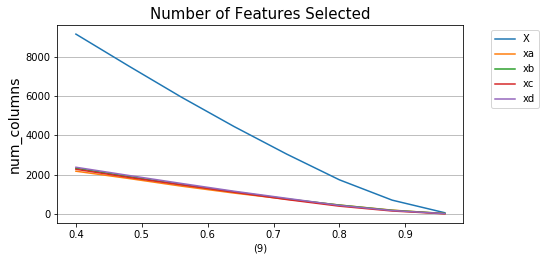

In [32]:
graph_threshold_scores(df = cos_reps_results, title = "Cos-Similarity between Reps", 
                       x_ax = 'threshold')

<a id='spearreps'><a/>
    
## 4. Spearman similarty between bioreps (drop features that are NOT similar between reps))
- Idea: same as before, but with a different ranking metric

In [36]:
#let's determine the approx thresh to use with the first dataframe
X_cos = xa.loc[:]
X_cos['BioRep'] = train_data['BioRep']       #add the biorep column to modified df
reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
X_cos = X_cos.drop(columns= ['BioRep'])

stats = []
for i in range(len(X_cos.columns)):
    stats.append(spearmanr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0])  

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats)) 

-0.0527930765348476
0.5624140565317035
-0.6886172650878534


In [39]:
np.arange(-0.4, 0.5, 0.1)

array([-4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
       -1.11022302e-16,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01])

In [42]:
dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['BioRep'] = train_data['BioRep']       #add the biorep column to modified df
    reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

#iterate thru cosine sim threshold   
    for j in np.arange(-0.4, 0.5, 0.1):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if spearmanr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0]  < drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names,axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [43]:
spear_reps_results = all_results.loc[:]
spear_reps_bestparams = spear_reps_results['best_params'].values
spear_reps_bestparams 

array([{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'sigmoid'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 0.01, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'sigmoid

In [44]:
spear_reps_results.drop('best_params', axis = 1).head()

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,-4.000000e-01,21827,0.362,0.775,-0.141,0.154,0.346,0.278,-0.372,0.752,-0.286,0.154,0.213,0.280,0.080
1,X,-3.000000e-01,20799,0.364,0.787,-0.140,0.131,0.345,0.285,-0.345,0.783,-0.311,0.133,0.217,0.287,0.107
2,X,-2.000000e-01,18325,0.386,0.798,-0.134,0.232,0.344,0.253,-0.311,0.797,-0.240,0.228,0.206,0.256,0.149
3,X,-1.000000e-01,14077,0.408,0.893,-0.089,0.322,0.336,0.223,-0.334,0.907,-0.253,0.323,0.208,0.224,0.119
4,X,-1.110223e-16,8956,0.414,0.892,-0.073,0.100,0.331,0.294,-0.300,0.894,-0.198,0.111,0.199,0.294,0.165


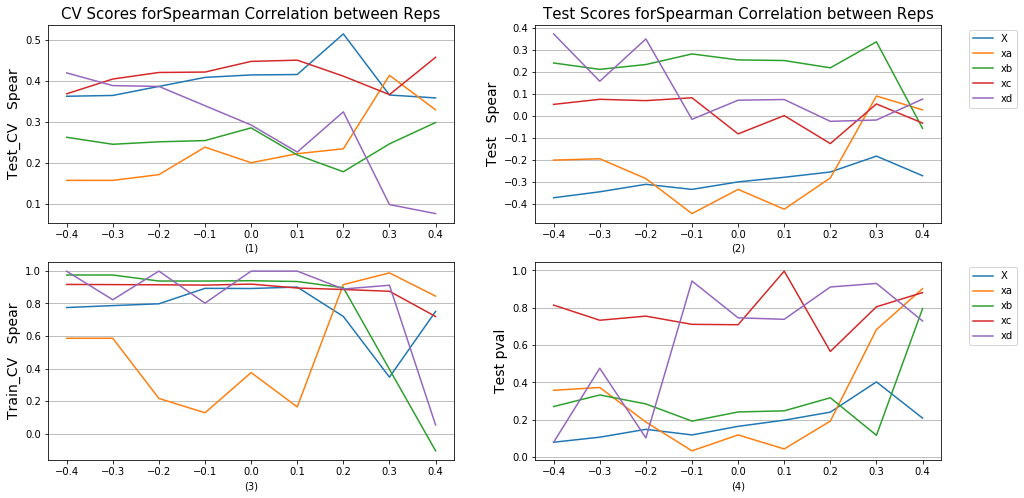

--------------------------------------------------------------------------


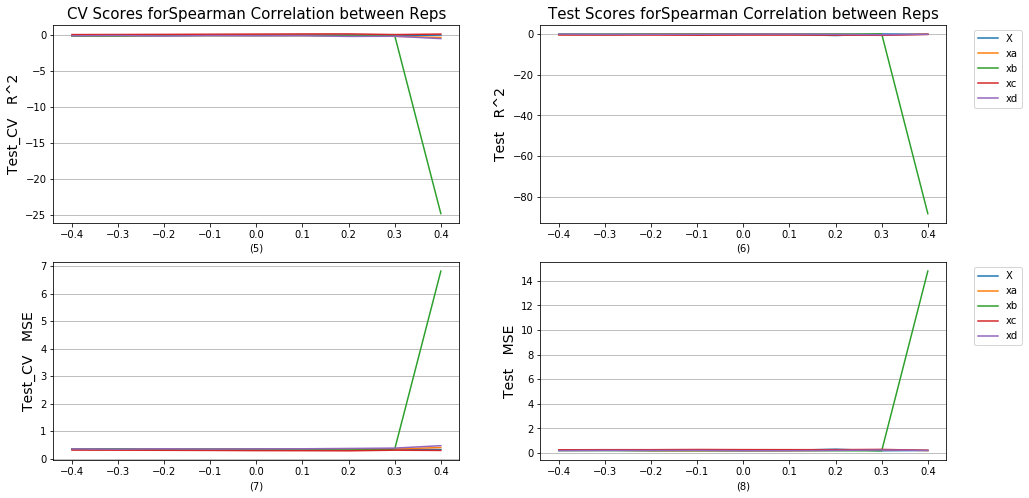

--------------------------------------------------------------------------


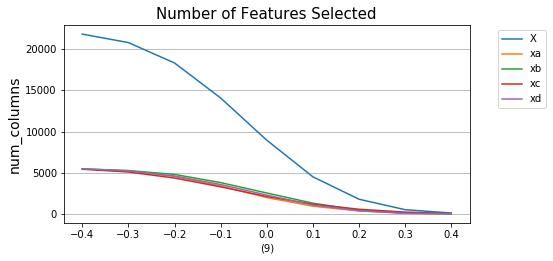

In [45]:
graph_threshold_scores(df = spear_reps_results, title = "Spearman Correlation between Reps", 
                       x_ax = 'threshold')

<a id='pearreps'><a/>
    
## 5.  Pearson correlation between bioreps (drop features that are NOT similar between reps)
- Idea: same as before, but with Pearson 

In [46]:
#determine the approx thresh to use with the first dataframe
X_cos = xa.loc[:]
X_cos['BioRep'] = train_data['BioRep']       
reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
X_cos = X_cos.drop(columns= ['BioRep'])

stats = []
for i in range(len(X_cos.columns)):
    stats.append(pearsonr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0])  

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats))  

-0.05526417233300892
0.545069457493701
-0.7035792836902263


In [63]:
np.arange(-0.2, 0.5, 0.08)

array([-0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,  0.44])

In [64]:
dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['BioRep'] = train_data['BioRep']       #add the biorep column to modified df
    reps1 = X_cos[X_cos['BioRep'] %2 != 0].drop(columns = ['BioRep'])
    reps2 = X_cos[X_cos['BioRep'] %2 == 0].drop(columns = ['BioRep'])
    X_cos = X_cos.drop(columns= ['BioRep'])

#iterate thru cosine sim threshold   
    for j in np.arange(-0.2, 0.5, 0.08):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if pearsonr(reps2.values[:,i].reshape(-1, 1),reps1.values[:,i].reshape(-1, 1))[0]  < drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names,axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [65]:
pear_reps_results = all_results.loc[:]
pear_reps_bestparams = pear_reps_results['best_params'].values
pear_reps_bestparams

array([{'C': 0.1, 'degree': 6, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 6, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 5, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'sigmoid'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 6, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},


In [66]:
pear_reps_results.drop('best_params', axis = 1).head()

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,-0.20,18335,0.381,0.822,-0.151,0.318,0.348,0.224,-0.322,0.840,-0.257,0.314,0.208,0.227,0.133
1,X,-0.12,14934,0.417,0.827,-0.150,0.325,0.348,0.222,-0.307,0.846,-0.247,0.321,0.207,0.225,0.155
2,X,-0.04,10800,0.437,0.891,-0.073,0.099,0.331,0.295,-0.366,0.893,-0.199,0.110,0.199,0.295,0.086
3,X,0.04,6769,0.450,0.943,-0.007,0.423,0.314,0.190,-0.347,0.940,-0.445,0.415,0.239,0.194,0.105
4,X,0.12,3649,0.467,0.840,-0.028,0.211,0.318,0.257,-0.244,0.825,-0.424,0.238,0.236,0.252,0.263


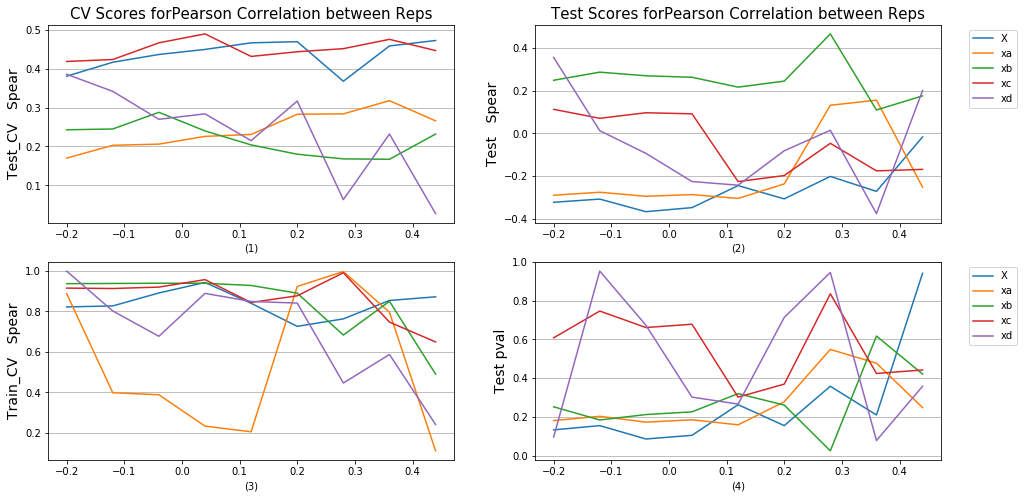

--------------------------------------------------------------------------


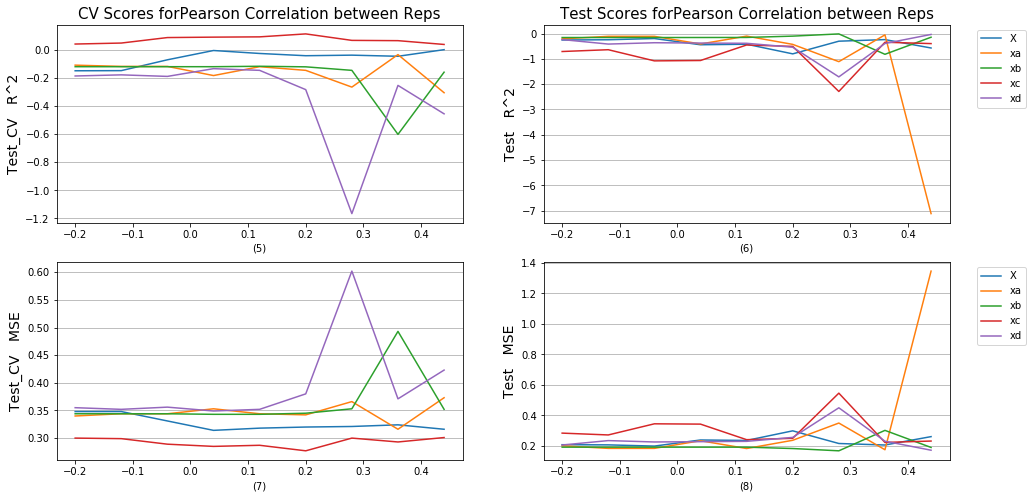

--------------------------------------------------------------------------


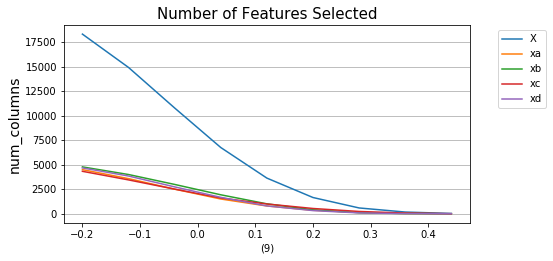

In [67]:
graph_threshold_scores(df = pear_reps_results, title = "Pearson Correlation between Reps", 
                       x_ax = 'threshold')

<a id='costreat'><a/>
## 6. Cosine similarity between treatments (drop genes that are highly similar)

- Idea: maybe some important features will behave differently in untreated vs treated
    - unlike rep1 vs rep1, important features will likely have different measurements in the treated vs untreated samples 
    - drop features that have a cos-sim score above the threshold (if a feature in untreated vs treated has a low similarity, keep it)

In [68]:
X_cos = xa.loc[:]
X_cos['Treatment'] = train_data['Treatment']
treat1 = X_cos[X_cos['Treatment']==1].drop(columns = ['Treatment'])
treat0 = X_cos[X_cos['Treatment']==0].drop(columns = ['Treatment'])
X_cos = X_cos.drop(columns= ['Treatment'])

stats = []
for i in range(len(X_cos.columns)):
    stats.append(cosine_similarity(treat1.values[:,i].reshape(1, -1), treat0.values[:,i].reshape(1, -1))[0][0])  

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats))  

0.32600535482892473
0.9819689391028834
-0.45842258048240453


In [69]:
np.arange(-0.2, 0.91, 0.1)

array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,
        0.9])

In [70]:
dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]
    
    X_cos = x_frame.loc[:]
    X_cos['Treatment'] = train_data['Treatment']
    treat1 = X_cos[X_cos['Treatment']==1].drop(columns = ['Treatment'])
    treat0 = X_cos[X_cos['Treatment']==0].drop(columns = ['Treatment'])
    X_cos = X_cos.drop(columns= ['Treatment'])

#iterate thru cosine sim threshold   
    for j in np.arange(-0.2, 0.91, 0.1):
        drop_point = j
        names = []
#drop the columns from the df that have cos sim between bioreps below certain threshold        
        for i in range(len(X_cos.columns)):
            if cosine_similarity(treat1.values[:,i].reshape(1, -1),treat0.values[:,i].reshape(1, -1))[0][0] > drop_point:
                names.append(X_cos.columns[i])                   
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [71]:
cos_treat_results = all_results.loc[:]
cos_treat_bestparams = cos_treat_results['best_params'].values
cos_treat_bestparams

array([{'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.01, 'degree': 6, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 

In [72]:
cos_treat_results.drop('best_params', axis = 1)

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,-0.2,692,0.347,0.529,-0.151,0.138,0.342,0.280,-0.156,0.481,-0.332,0.089,0.221,0.302,0.479
1,X,-0.1,1752,0.395,0.887,-0.068,0.130,0.329,0.285,-0.260,0.868,-0.221,0.134,0.202,0.287,0.232
2,X,0.0,3517,0.441,0.947,-0.141,0.288,0.347,0.232,0.129,0.945,-0.176,0.287,0.195,0.236,0.558
3,X,0.1,5810,0.445,0.954,-0.127,0.436,0.345,0.185,0.049,0.973,-0.150,0.434,0.191,0.188,0.824
4,X,0.2,8293,0.372,0.943,-0.122,0.190,0.344,0.265,-0.013,0.947,-0.159,0.191,0.192,0.268,0.953
5,X,0.3,10666,0.339,0.876,-0.090,0.244,0.335,0.248,-0.315,0.881,-0.202,0.248,0.199,0.249,0.143
6,X,0.4,12901,0.414,0.935,-0.093,0.236,0.335,0.250,-0.302,0.938,-0.215,0.235,0.201,0.253,0.162
7,X,0.5,14974,0.352,0.967,-0.057,0.487,0.326,0.169,-0.326,0.972,-0.314,0.475,0.218,0.174,0.128
8,X,0.6,16933,0.370,0.918,-0.056,0.320,0.328,0.224,-0.302,0.907,-0.290,0.322,0.214,0.224,0.161
9,X,0.7,18724,0.374,0.926,-0.041,0.359,0.324,0.212,-0.362,0.920,-0.339,0.357,0.222,0.213,0.090


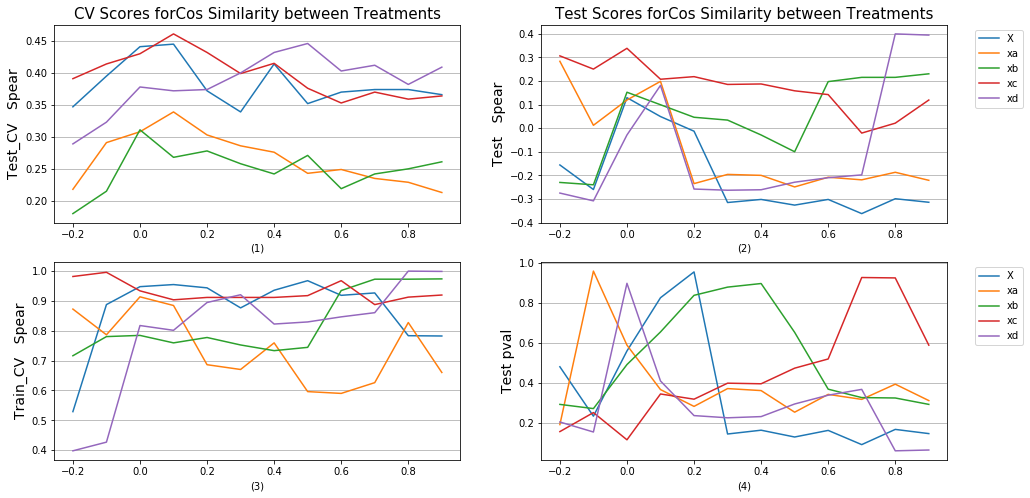

--------------------------------------------------------------------------


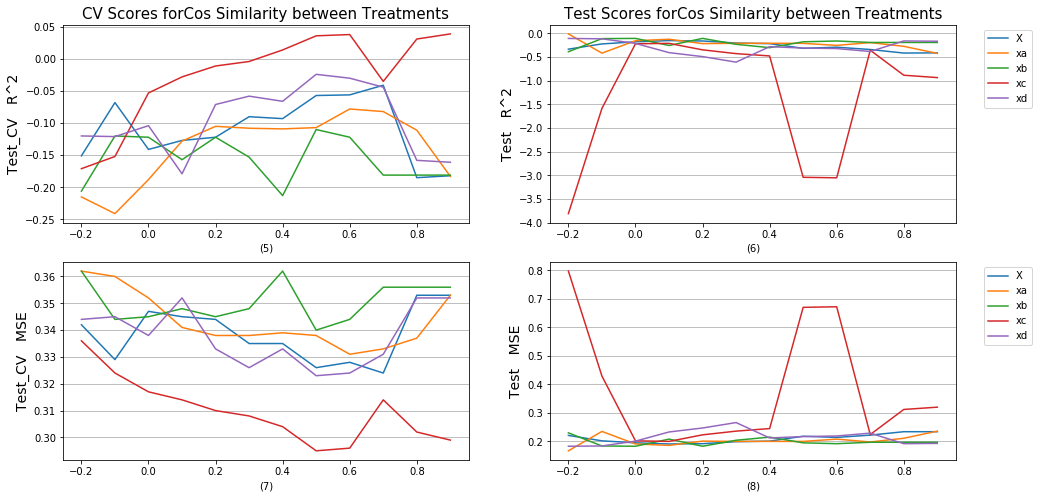

--------------------------------------------------------------------------


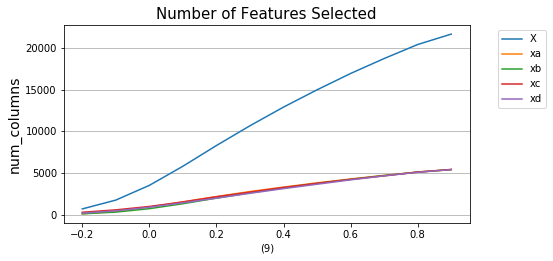

In [73]:
graph_threshold_scores(df = cos_treat_results, title = "Cos Similarity between Treatments", 
                       x_ax = 'threshold')

<a id='speartar'><a/>
## 7. Spearman Correlation with Target


In [74]:
#check the threshold with the first df
X_cos = xa.loc[:]
stats = []
  
for c in range(len(X_cos.columns)):   
    stats.append(spearmanr(X_cos.iloc[:, c].values.reshape(-1, 1), y.values.reshape(-1, 1))[0])  
    
print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats)) 

0.01597085460126366
0.34043552066361976
-0.3410852067717565


In [75]:
dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]   
    X_cos = x_frame.loc[:]
#iterate thru threshold
    for j in np.arange(0.02, 0.32, 0.04):
        names = []
#drop the columns that spear rank with target below certain threshold        
        for c in range(len(X_cos.columns)):
#             s, p = spearmanr(X_cos.iloc[:, c].values.reshape(-1, 1), y_frame.values.reshape(-1, 1))
            s, p = spearmanr(X_cos.iloc[:, c], y_frame.values)
            if np.abs(s) < j:
                names.append(X_cos.columns[c])   
                   
                
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [76]:
spear_tar_results = all_results.loc[:]
spear_tar_bestparams = spear_tar_results['best_params'].values
spear_tar_bestparams

array([{'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'rbf'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'rbf'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.01, 'kernel': 'sigmoid'},
       {'C': 1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 4, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'sigmoid'},
   

In [77]:
spear_tar_results.drop('best_params', axis = 1).head()

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,0.02,19583,0.391,0.782,-0.179,0.018,0.352,0.321,-0.313,0.767,-0.400,0.010,0.232,0.328,0.146
1,X,0.06,14716,0.439,0.895,-0.114,0.219,0.342,0.256,-0.034,0.896,-0.158,0.217,0.192,0.259,0.879
2,X,0.10,10142,0.568,0.942,-0.119,0.192,0.343,0.264,-0.154,0.950,-0.158,0.193,0.192,0.267,0.484
3,X,0.14,6249,0.599,0.759,-0.048,0.089,0.324,0.299,-0.047,0.764,-0.078,0.099,0.179,0.298,0.833
4,X,0.18,3303,0.638,0.999,-0.158,0.903,0.352,0.031,0.195,0.999,-0.168,0.901,0.194,0.033,0.373


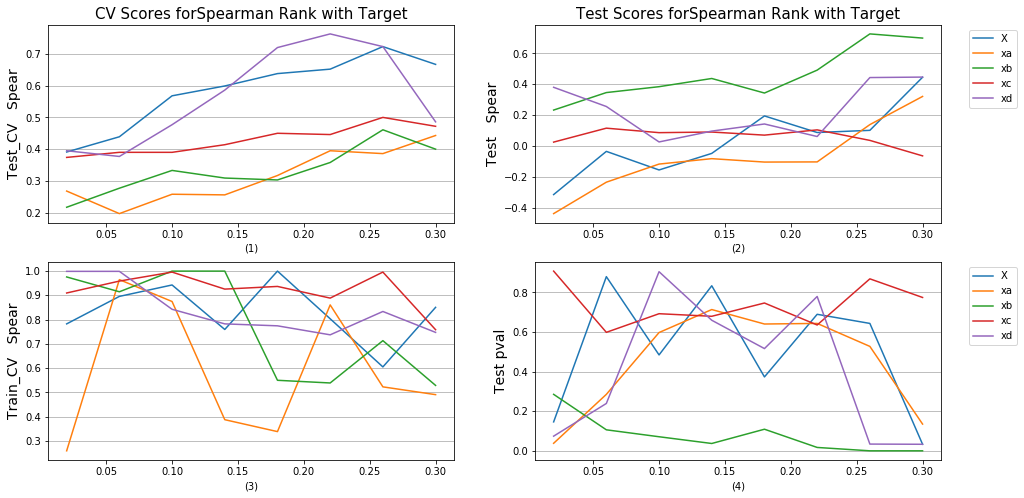

--------------------------------------------------------------------------


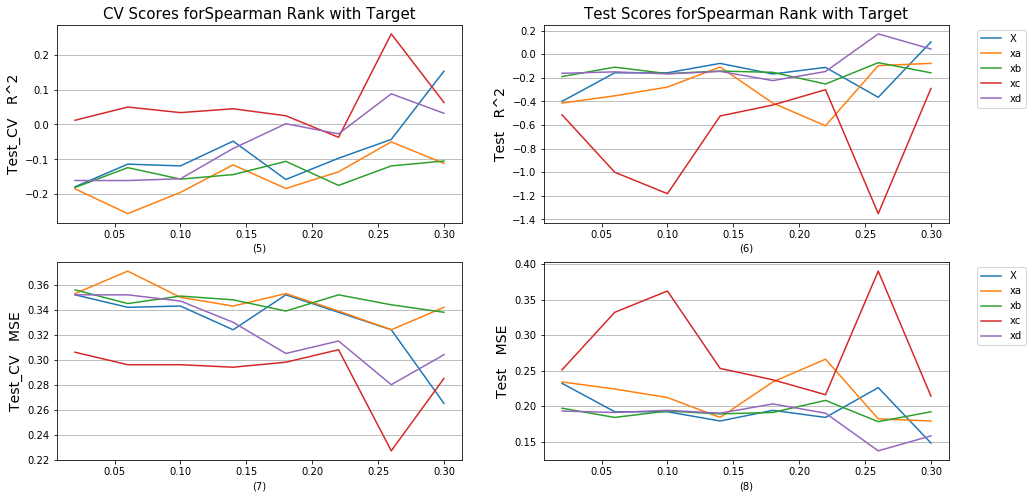

--------------------------------------------------------------------------


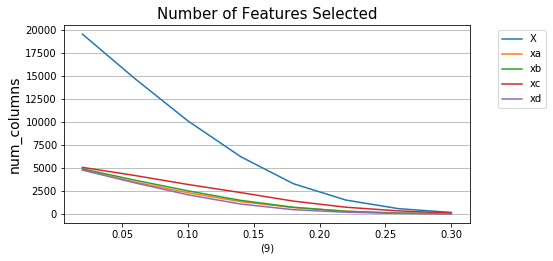

In [78]:
graph_threshold_scores(df = spear_tar_results, title = "Spearman Rank with Target", 
                       x_ax = 'threshold')

<a id='peartar'><a/>
    
## 8. Pearson Correlarion with Target


In [79]:
#check the threshold with the first df
X_cos = xa.loc[:]
stats = []
  
for c in range(len(X_cos.columns)):  
    stats.append(pearsonr(X_cos.iloc[:, c].values.reshape(-1, 1), y.values.reshape(-1, 1))[0])  
    
print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats)) 

0.008031400347240555
0.3492187637170987
-0.3007287297051175


In [80]:
np.arange(0.02, 0.32, 0.04)

array([0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 ])

In [81]:
dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]   
    X_cos = x_frame.loc[:]
#iterate thru threshold
    for j in np.arange(0.02, 0.32, 0.04):
        names = []
#drop the columns that spear rank with target below certain threshold        
        for c in range(len(X_cos.columns)):     
            s, p = pearsonr(X_cos.iloc[:, c].values.reshape(-1, 1), y_frame.values.reshape(-1, 1))
            if np.abs(s) < j:
                names.append(X_cos.columns[c])   
                               
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [82]:
pears_tar_results = all_results.loc[:]
pears_tar_bestparams = pears_tar_results['best_params'].values
pears_tar_bestparams

array([{'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 1, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'poly'},
       {'C': 5, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'rbf'},
       {'C': 5, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'},
       {'C': 0.01, 'degree': 4, 'epsilon': 0.1, 'gamma': 0.001, 'kernel': 'poly'},
       {'C': 1, 'degree': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 6, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'poly'},
    

In [91]:
pears_tar_results.drop('best_params', axis = 1)

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,0.02,19156,0.405,0.785,-0.179,0.018,0.352,0.321,-0.309,0.778,-0.399,0.011,0.232,0.328,0.152
1,X,0.06,13305,0.477,0.872,-0.052,0.114,0.325,0.290,-0.246,0.856,-0.184,0.128,0.196,0.289,0.259
2,X,0.10,8442,0.574,0.867,0.082,0.373,0.287,0.205,-0.104,0.864,-0.250,0.376,0.207,0.207,0.637
3,X,0.14,4816,0.632,0.873,0.148,0.412,0.268,0.192,0.043,0.876,-0.113,0.410,0.184,0.195,0.845
4,X,0.18,2424,0.670,0.883,0.231,0.470,0.241,0.172,0.107,0.895,-0.070,0.493,0.177,0.168,0.627
5,X,0.22,1081,0.736,0.964,0.469,0.973,0.167,0.008,0.421,0.970,0.036,0.978,0.160,0.007,0.045
6,X,0.26,354,0.691,0.958,0.442,0.912,0.169,0.027,0.422,0.969,0.108,0.926,0.148,0.024,0.045
7,X,0.30,85,0.706,0.795,0.160,0.579,0.244,0.136,0.400,0.667,-0.388,0.184,0.230,0.270,0.059
8,xa,0.02,4672,0.289,0.237,-0.185,-0.000,0.353,0.327,-0.487,0.308,-0.415,-0.010,0.234,0.334,0.018
9,xa,0.06,2960,0.252,0.944,-0.157,0.481,0.345,0.165,-0.155,0.935,-0.283,0.464,0.213,0.177,0.481


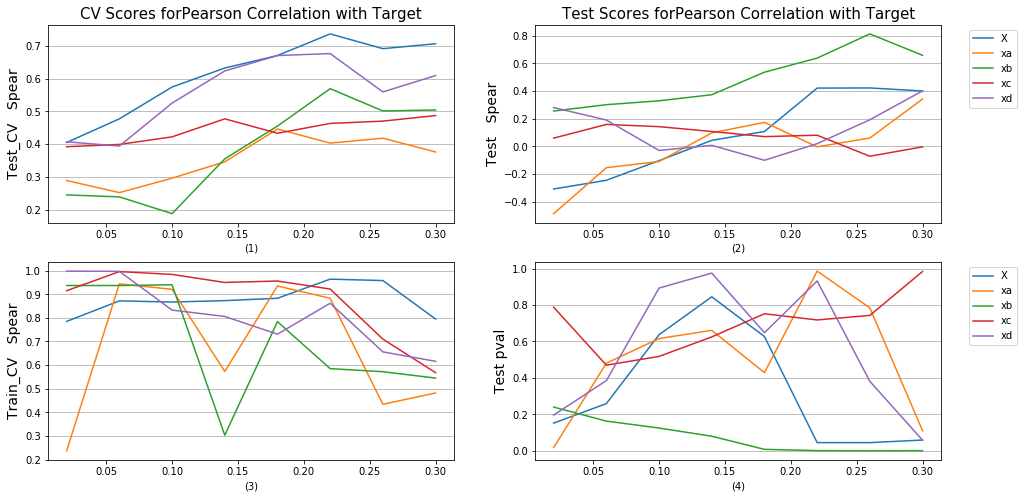

--------------------------------------------------------------------------


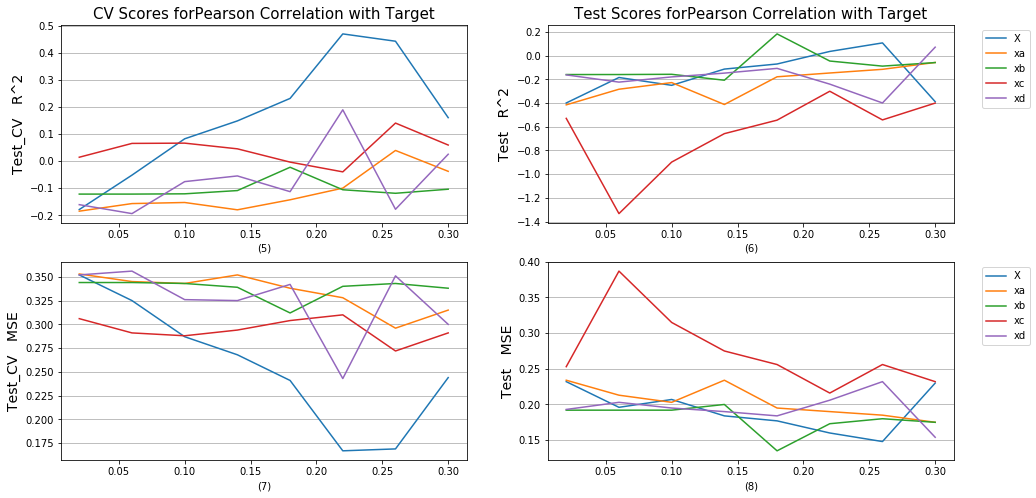

--------------------------------------------------------------------------


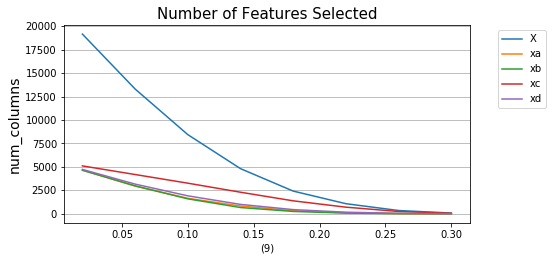

In [84]:
graph_threshold_scores(df = pears_tar_results, title = "Pearson Correlation with Target", 
                       x_ax = 'threshold')

<a id='costar'><a/>
## 9. Cosine similarity with Target

In [85]:
#check the threshold with the first df
X_cos = xa.loc[:]
stats = []
for i in range(len(X_cos.columns)):
    stats.append(cosine_similarity(X_cos.values[:, i].reshape(1, -1), y.values.reshape(1, -1))[0][0])

print(np.mean(stats))                
print(np.max(stats))                  
print(np.min(stats))  


0.06967646160661485
0.9336040594295273
-0.9383008613221125


In [86]:
np.arange(0.1, 0.98, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [87]:
dataframe = []    #for gridsearch results
threshold = []
best_params = []
gs_test_spear = []
gs_train_spear = []
gs_test_r2 = []
gs_train_r2 = []
gs_test_mse = []
gs_train_mse = []
num_columns = []

test_spear = []   #for final scores
train_spear = []
test_r2 = []
train_r2 = []
test_mse = []
train_mse = []
test_pval = []

#iterate thru each dataframe 
for x in list(zip(X_frames, y_frames)):
    x_frame = globals()[x[0]]
    y_frame = globals()[x[1]]   
    X_cos = x_frame.loc[:]
#iterate thru threshold
    for j in np.arange(0.1, 0.98, 0.1):
        names = []
#drop the columns that spear rank with target below certain threshold        
        for c in range(len(X_cos.columns)):
            s = cosine_similarity(X_cos.values[:, c].reshape(1, -1), y_frame.values.reshape(1, -1))[0][0]
            if np.abs(s) < j:
                names.append(X_cos.columns[c])   
                               
        X_new = X_cos.drop(names, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_new, y_frame.values.ravel(), 
                                                            test_size = 0.33, random_state = 33)
#gridsearch
        svc = svm.SVR()
        params = {        
                     'kernel': ['rbf', 'poly', 'sigmoid'],
                          'C': [0.01, 0.1, 1, 5],
                    'epsilon': [0.01,  0.1, 0.2],
                      'gamma': [0.001, 0.01, 'auto'], 
                     'degree': [2, 4, 6]                  }

        scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse':make_scorer(mean_squared_error)}
        gs = GridSearchCV(svc, param_grid= params,  cv=3, verbose = 0, 
                          return_train_score=True, scoring = scoring, refit = 'spear_r')
        gs.fit(X_train, y_train) 
        gs_results = pd.DataFrame(gs.cv_results_)
        best_scores_df = gs_results[gs_results['rank_test_spear_r'] == 1].reset_index(drop = True) 
#gridsearch results df    
        dataframe.append(x[0])
        threshold.append(j)
        best_params.append(best_scores_df.loc[0, 'params'])
        gs_test_spear.append(round(best_scores_df.loc[0, 'mean_test_spear_r' ], 3))
        gs_train_spear.append(round(best_scores_df.loc[0, 'mean_train_spear_r'], 3))
        gs_test_r2.append(round(best_scores_df.loc[0, 'mean_test_r2'], 3))
        gs_train_r2.append(round(best_scores_df.loc[0, 'mean_train_r2'], 3))
        gs_test_mse.append(round(best_scores_df.loc[0, 'mean_test_mse'], 3))
        gs_train_mse.append(round(best_scores_df.loc[0, 'mean_train_mse'], 3))
        num_columns.append(len(X_new.columns))
# final score using the best gridsearch params
        svc = svm.SVR(kernel = gs.best_params_['kernel'], C = gs.best_params_['C'], degree = gs.best_params_['degree'], 
                     epsilon = gs.best_params_['epsilon'], gamma = gs.best_params_['gamma'])
        model = svc.fit(X_train, y_train)
        pred = model.predict(X_test)
        train_pred = model.predict(X_train)
#for final score df             
        test_spear.append(round(spearmanr(y_test, pred)[0], 3))
        test_r2.append(round(r2_score(y_test, pred), 3))
        test_mse.append(round(mean_squared_error(y_test, pred), 3))
        test_pval.append(round(spearmanr(y_test, pred)[1], 3))
        train_spear.append(round(spearmanr(y_train, train_pred)[0], 3))
        train_r2.append(round(r2_score(y_train, train_pred), 3))
        train_mse.append(round(mean_squared_error(y_train, train_pred), 3))
        

all_results = pd.DataFrame(list(zip(dataframe, threshold, num_columns, best_params, gs_test_spear, gs_train_spear, gs_test_r2, 
    gs_train_r2, gs_test_mse, gs_train_mse,test_spear, train_spear, test_r2, train_r2, test_mse, train_mse, test_pval)),
            columns=['x_frame', 'threshold', 'num_columns', 'best_params', 'gs_test_spear','gs_train_spear','gs_test_r2', 
                     'gs_train_r2','gs_test_mse', 'gs_train_mse','test_spear', 'train_spear', 'test_r2', 'train_r2',
                     'test_mse', 'train_mse', 'test_pval'])

In [88]:
cos_tar_results = all_results.loc[:]
cos_tar_bestparams = cos_tar_results['best_params'].values
cos_tar_bestparams

array([{'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 5, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'},
       {'C': 1, 'degree': 2, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'rbf'},
       {'C': 0.01, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'gamma': 0.001, 'kernel': 'sigmoid'},
       {'C': 0.1, 'degree': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'poly'},
       {'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'gamma': 'auto', 'kernel': 'poly

In [89]:
cos_tar_results.drop('best_params', axis = 1).head()

,x_frame,threshold,num_columns,gs_test_spear,gs_train_spear,gs_test_r2,gs_train_r2,gs_test_mse,gs_train_mse,test_spear,train_spear,test_r2,train_r2,test_mse,train_mse,test_pval
0,X,0.1,20294,0.367,0.776,-0.180,0.019,0.352,0.321,-0.325,0.752,-0.401,0.011,0.232,0.328,0.130
1,X,0.2,18374,0.362,0.777,-0.134,0.178,0.345,0.271,-0.372,0.754,-0.274,0.174,0.211,0.273,0.081
2,X,0.3,16335,0.358,0.771,-0.178,0.023,0.352,0.319,-0.344,0.753,-0.396,0.016,0.231,0.326,0.108
3,X,0.4,14239,0.362,0.899,-0.048,0.471,0.327,0.176,-0.440,0.899,-0.511,0.451,0.250,0.182,0.036
4,X,0.5,11951,0.332,0.776,-0.180,0.015,0.352,0.322,-0.337,0.770,-0.408,0.006,0.233,0.329,0.116


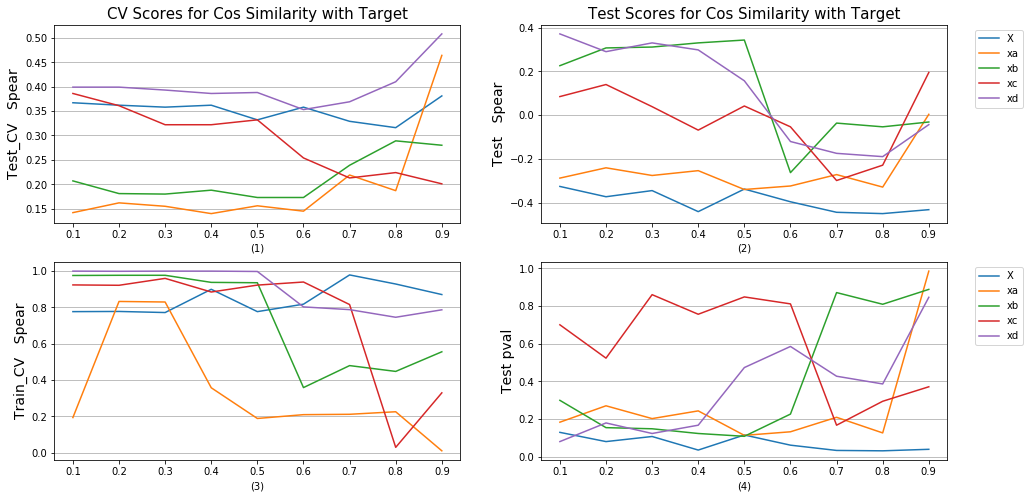

--------------------------------------------------------------------------


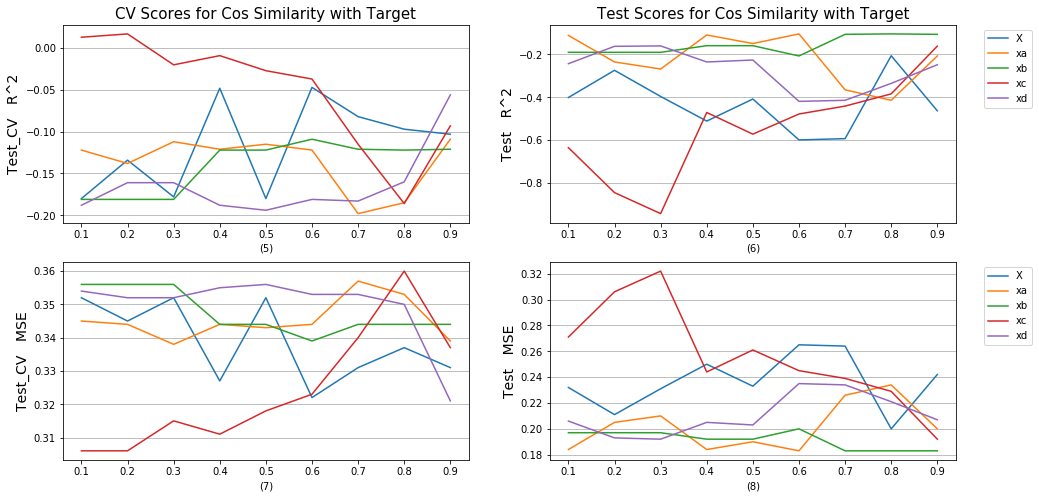

--------------------------------------------------------------------------


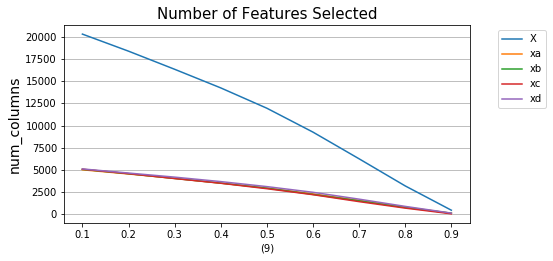

In [90]:
graph_threshold_scores(df = cos_tar_results, title = " Cos Similarity with Target", 
                       x_ax = 'threshold')